## Задание 1. Как учитывать заголовок?

Для экономии ресурсов можно вообще пытаться оценивать по заголовку, так как мы часто можем определить ещё по заоловку письма спам это или нет. Но с другой стороны, заголовок лишь помогает суммировать то, что в тексте, поэтому его можно обрабатывать наравне с текстом или вообщещ не обрабатывать.

## Задание 2. Векторизация текста

In [1]:
import csv
import os

folder = os.path.dirname("C:\\Users\\agata\\Documents\\itmo\\andan\\Lab5\\messages\\")
file_list = os.listdir(folder)
#print(folder_list)

with open("data.csv", "w") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['name', 'subject','message'])
    for file in file_list:
            with open(os.path.join(folder, file), "r")  as infile:
                contents = infile.read().split("\n\n")
                outfile.write(file+',')
                outfile.write(contents[0] + ',')
                outfile.write(contents[1])
                

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("data.csv")
data

,name,subject,message
0,100legit29.txt,Subject: 2056 118 22577 20908 14616,284 14851 80 16147 17345 14338 130 19410 47 58...
1,101002legit41.txt,Subject: 2056 118 14140 84 13147 1613 383 80 1...,284 4353 47 17011 15691 9997 18783 1613 1613 9...
2,101006legit31.txt,Subject: 2056 118 10542 1359 2268 1822,8962 180 2331 1967 4602 24704 196 18464 2130 9...
3,101011spmsg62.txt,Subject: 20259 82 23231 86 16667 82 9634 86 16...,7062 118 22880 4177 5762 80 17713 2519 13406 1...
4,101019spmsg88.txt,Subject: 22180 14988 47,10769 13520 19074 51 305 51 16263 16296 19054 ...
...,...,...,...
1085,9975legit14.txt,Subject: 2056 118 11457 17524 15836 68 11521 4...,16733 19054 118 6306 118 86 86 17212 84 1672 8...
1086,9979spmsg74.txt,Subject: 4053 4074 4532,10179 1968 15193 1812 17345 21366 16502 17154 ...
1087,9990legit50.txt,Subject: 2056 118 21215 1662 1835 10470,284 13383 80 127 24731 2328 2130 130 21196 84 ...
1088,9994legit44.txt,Subject: 20787,183 180 205 205 191 214 227 219 180 219 190 22...


In [4]:
final_data = data.copy()
final_data.subject = final_data.subject.map(lambda sub: sub.replace("Subject: ", ''))
final_data['is_spam'] = final_data.name.map(lambda name: "spmsg" in name)
final_data['is_legit'] = final_data.name.map(lambda name: "legit" in name)
final_data.drop('name', inplace = True, axis =1)
final_data.to_csv('final_data.csv', index=False)
final_data.describe()

,subject,message,is_spam,is_legit
count,1090,1090,1090,1090
unique,936,1062,2,2
top,,19054 1847 15691 18844 123 17345 13472 9537 19...,False,True
freq,23,5,610,610


In [5]:
from scipy.sparse import hstack
def vectorize_data(data, vectorize_data_column, columns = ['subject', 'message'], is_train = True, vectorizers = None):
    assert is_train == (vectorizers is None)
    vectorized_datas = []
    if is_train:     
        vectorizers = {}
        for column in columns:
            vectorizer, vectorized_data = vectorize_data_column(data, column, is_train)
            vectorizers[column] = vectorizer
            vectorized_datas.append(vectorized_data)
        return vectorizers, hstack(vectorized_datas)
    else:
        for column in columns:
            vectorized_data = vectorize_data_column(data, column, is_train, vectorizer = vectorizers[column])
            vectorized_datas.append(vectorized_data)
        return hstack(vectorized_datas)

In [6]:
df = pd.read_csv("final_data.csv")
df['all'] = df['subject'].map(str) + " " + df['message'].map(str)

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2)
train_y = train.is_spam.astype(int)
test_y = test.is_spam.astype(int)

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
def count_vectorize(data, column, is_train, vectorizer = None):
    if is_train:
        vectorizer = CountVectorizer()
        vect_data = vectorizer.fit_transform(data[column].values.astype('U'))
        return vectorizer, vect_data
    else:
        vect_data = vectorizer.transform(data[column].values.astype('U'))
        return vect_data

In [9]:
def binary_vectorize(data, column, is_train, vectorizer = None):
    if is_train:
        vectorizer = CountVectorizer(binary = True)
        vect_data = vectorizer.fit_transform(data[column].values.astype('U'))
        return vectorizer, vect_data
    else:
        vect_data = vectorizer.transform(data[column].values.astype('U'))
        return vect_data

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_vectorize(data, column, is_train, vectorizer = None):
    if is_train:
        vectorizer = TfidfVectorizer()
        vect_data = vectorizer.fit_transform(data[column].values.astype('U'))
        return vectorizer, vect_data
    else:
        vect_data = vectorizer.transform(data[column].values.astype('U'))
        return vect_data

In [11]:
#has_subject = True|False
#vectoriser = 'Count', 'Tf-IDF', 'Binary'
def train_test_X(has_subject, vectorizer):
    
    if vectorizer == "Count":
        vectorize_data_column = count_vectorize
    elif vectorizer == 'Tf-IDF':
        vectorize_data_column = tfidf_vectorize
    elif vectorizer == 'Binary':
        vectorize_data_column = binary_vectorize
    if has_subject:
        vectorizers, train_X = vectorize_data(train, vectorize_data_column)
        #print(vectorizers)
        test_X = vectorize_data(test, vectorize_data_column, is_train = False, vectorizers = vectorizers)
    else:
        vectorizers, train_X = vectorize_data(train, vectorize_data_column, columns = ['all'])
        test_X = vectorize_data(test, vectorize_data_column, is_train = False, vectorizers = vectorizers, columns = ['all'])
    return train_X, test_X

In [12]:
# try count vectorizer with separated data
train_X, test_X = train_test_X(True, 'Count')

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
def predict(train, test, p_is_spam = None):
    if p_is_spam is None:
        clf = MultinomialNB()
    else:
        clf = MultinomialNB(class_prior = [p_is_spam, 1 - p_is_spam])
    '''params = {'alpha': np.arange(0.1, 1.0, 0.1)}
    clf_learned = GridSearchCV(clf, params)'''
    clf.fit(train, train_y)
    pred_proba = clf.predict_proba(test)
    pred = clf.predict(test)
    #print(pred)
    return clf, pred_proba, pred
clf, pred_proba, pred = predict(train_X, test_X)

In [14]:
from sklearn.metrics import mean_absolute_percentage_error
def compare(pred):
    diff = 0
    print(test.shape[0], pred.size, test_y.size)
    '''for i in range (test.shape[0]):
        if(pred[i] != test_y.values[i]):
            diff += 1
    print(diff, "/", test.shape[0])'''
    print(mean_absolute_percentage_error(2**pred[::,1],2**test_y))
compare(pred_proba)

218 436 218
0.02733290615000138


In [15]:
#has_subject = True|False
#vectoriser = 'Count', 'Tf-IDF', 'Binary'
def fit_and_predict(has_subject, vectorizer, p_is_spam = None, with_log = True, ret_score = False):
    if with_log:
        print("Subject and message separated" if has_subject else "Subject and message united")
        print("Vectroizer is " + vectorizer)
    train_X, test_X = train_test_X(has_subject, vectorizer)
    clf, pred_proba, pred = predict(train_X, test_X, p_is_spam)
    if with_log:
        compare(pred_proba)
    if(ret_score):
        return clf, pred_proba, pred, clf.score(test_X, test_y)
    return clf, pred_proba, pred

## Comparing

In [16]:
_ = fit_and_predict(True, 'Count')
_ = fit_and_predict(False, 'Count')

Subject and message separated
Vectroizer is Count
218 436 218
0.02733290615000138
Subject and message united
Vectroizer is Count
218 436 218
0.02661248214115084


In [17]:
_ = fit_and_predict(True, 'Tf-IDF')
_ = fit_and_predict(False, 'Tf-IDF')

Subject and message separated
Vectroizer is Tf-IDF
218 436 218
0.09842255674873765
Subject and message united
Vectroizer is Tf-IDF
218 436 218
0.1799503269931104


In [18]:
fit_and_predict(True, 'Binary')
_ = fit_and_predict(False, 'Binary')

Subject and message separated
Vectroizer is Binary
218 436 218
0.018390638318630127
Subject and message united
Vectroizer is Binary
218 436 218
0.018291405201014584


## ROC-кривая

In [19]:
from sklearn.metrics import roc_curve, auc
def roc_auc(has_subject, vectorizer):
    clf, pred_proba, pred = fit_and_predict(has_subject, vectorizer)
    #print(test_y, pred[::, 1])
    fpr, tpr, _ = roc_curve(test_y, pred_proba[::, 1])
    #print(fpr, tpr)
    plt.plot(fpr, tpr, label="AUC="+str(auc(fpr, tpr)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    

Subject and message separated
Vectroizer is Count
218 436 218
0.02733290615000138


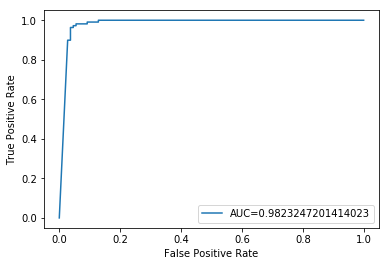

Subject and message united
Vectroizer is Count
218 436 218
0.02661248214115084


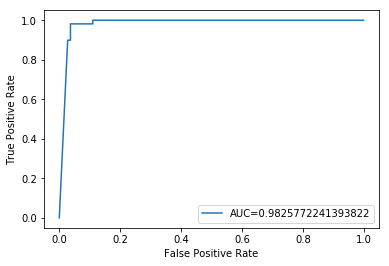

In [20]:
roc_auc(True, 'Count')
roc_auc(False, 'Count')

Subject and message separated
Vectroizer is Binary
218 436 218
0.018390638318630127


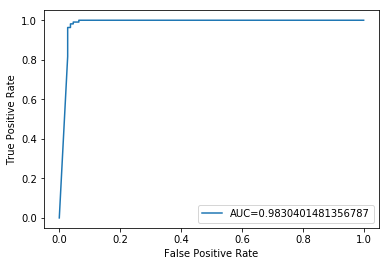

Subject and message united
Vectroizer is Binary
218 436 218
0.018291405201014584


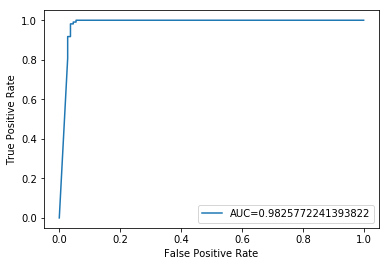

In [21]:
roc_auc(True, 'Binary')
roc_auc(False, 'Binary')


## Априорное распределение

False Positive Rate - это доля неправильно предсказанных классов среди объектов отрицательного класса. Значит, мы хотим, чтобы FPR = 0, так как тогда доля предсказанных как спам неспамовых писем будет нулевой.

In [22]:
clf, pred_proba, pred = fit_and_predict(True, 'Binary', with_log = False)

In [32]:
def find_prior_probabilities():
    max_score = 0
    best_prior_probabilities = None
    part = 1e-16
    for p in np.arange(1 - part, 1, part/10):
        clf, pred_proba, pred, score = fit_and_predict(True, 'Binary', p, with_log = False, ret_score = True)
        legit = np.argwhere(test_y.values == 0)
        #fpr, tpr, _ = roc_curve(test_y, pred, drop_intermediate = False)
        #curr_auc = auc(fpr, tpr)
        
        print(pred[legit].sum(), score)
        if (score > max_score and pred[legit].sum() == 0):
            max_score = score
            best_prior_probabilities = [p, 1 - p]
            print("Точность:", max_score, "Вероятность:", p)
    return best_prior_probabilities
find_prior_probabilities()


2 0.8899082568807339
2 0.8899082568807339
2 0.8899082568807339
2 0.8899082568807339
2 0.8899082568807339
2 0.8899082568807339
2 0.8899082568807339
2 0.8899082568807339
2 0.8899082568807339
2 0.8899082568807339
2 0.8899082568807339
2 0.8899082568807339


In [24]:
'''def find_probabilities():
    max_score = 0
    best_prior_probabilities = None
    part = 1e-15
    l = 1 - part
    r = 1
    eps = 1e-18
    while(r - l > eps):
        m = (l + r) / 2
        print(m)
        clf, pred_proba, pred, score = fit_and_predict(True, 'Binary', m, with_log = False, ret_score = True)
        legit = np.argwhere(test_y.values == 0)
        if (pred[legit].sum() == 0):
            r = m
        else:
            l = m
    best_prior_probabilities = [r, 1 - r]
    return best_prior_probabilities
find_probabilities()'''

"def find_probabilities():\n    max_score = 0\n    best_prior_probabilities = None\n    part = 1e-15\n    l = 1 - part\n    r = 1\n    eps = 1e-18\n    while(r - l > eps):\n        m = (l + r) / 2\n        print(m)\n        clf, pred_proba, pred, score = fit_and_predict(True, 'Binary', m, with_log = False, ret_score = True)\n        legit = np.argwhere(test_y.values == 0)\n        if (pred[legit].sum() == 0):\n            r = m\n        else:\n            l = m\n    best_prior_probabilities = [r, 1 - r]\n    return best_prior_probabilities\nfind_probabilities()"

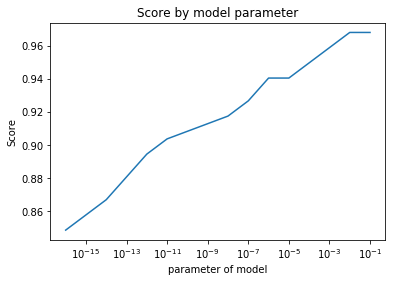

In [25]:
scores = []
ps = []
for pw in range(-16, 0):
    p = 10 ** pw
    ps.append(p)
    clf, pred_proba, pred, score = fit_and_predict(True, 'Binary', p, with_log = False, ret_score = True)
    fpr, tpr, thresholds = roc_curve(test_y, pred_proba[:, 1])
    scores.append(score)

plt.xscale('log')
plt.plot(ps, scores)
plt.ylabel('Score')
plt.xlabel('parameter of model')
plt.title('Score by model parameter')
plt.show()